# LAB3
## MohammadParsa Dini 400101204

In [1]:
Name = "MohammadParsa Dini"
StudentId = "400101204"

### Importing Required Libraries 

In [1]:
import torch

if torch.cuda.is_available():
    torch.device = 'cuda'
    print('running on gpu')
else:    
    torch.device = 'cpu'
    print('running on cpu')

running on gpu


In [4]:
import os
import cv2
import numpy as np

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.linalg import eigh
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


We begin by calculating the overall mean and the means of each class (happy, surprise, neutral, and disgust). Next, we create scatter matrices for each class and the overall data. The within-class scatter matrix 
$S_W$
 is computed as the sum of the scatter matrices for each class, representing the difference between the data points of a class and the class mean. The between-class scatter matrix 
$S_B$
 is calculated using the difference between each class mean and the overall mean, weighted by the number of samples in each class. We then calculate the combined matrix 
${S_W}^{−1} S_B$
 and find its eigenvalues and eigenvectors. Finally, we project the test data onto these eigenvectors and classify each test sample by comparing its distance from the mean of each class.

In [5]:
# Image paths
path_happy = 'Cohn-Kanade/images/happy'
path_surprise = 'Cohn-Kanade/images/surprise'

def load_images(path, label):
    images = []
    labels = []
    for file in os.listdir(path):
        img = cv2.imread(os.path.join(path, file), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (64, 64))  # Resize for uniformity
            images.append(img.flatten())
            labels.append(label)
    return np.array(images), np.array(labels)

# Load happy and surprise images
happy_images, happy_labels = load_images(path_happy, 0)  # 0 for happy
surprise_images, surprise_labels = load_images(path_surprise, 1)  # 1 for surprise

# Combine data from both classes
images = np.vstack((happy_images, surprise_images))
labels = np.hstack((happy_labels, surprise_labels))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, stratify=labels, train_size=52, random_state=42)


In [7]:
# Create PCA for dimensionality reduction to 50
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)  # Fit only with the training data
X_test_pca = pca.transform(X_test)        # Dimensionality reduction for the test data


In [8]:
# Calculate overall mean and mean of each class
mean_total = np.mean(X_train_pca, axis=0)
mean_happy = np.mean(X_train_pca[y_train == 0], axis=0)
mean_surprise = np.mean(X_train_pca[y_train == 1], axis=0)

# Calculate within-class scatter SW
S_W = np.zeros((50, 50))
for x in X_train_pca[y_train == 0]:  # For happy class
    S_W += (x - mean_happy).reshape(-1, 1) @ (x - mean_happy).reshape(1, -1)
for x in X_train_pca[y_train == 1]:  # For surprise class
    S_W += (x - mean_surprise).reshape(-1, 1) @ (x - mean_surprise).reshape(1, -1)

# Calculate between-class scatter SB
n_happy = np.sum(y_train == 0)
n_surprise = np.sum(y_train == 1)
S_B = n_happy * (mean_happy - mean_total).reshape(-1, 1) @ (mean_happy - mean_total).reshape(1, -1)
S_B += n_surprise * (mean_surprise - mean_total).reshape(-1, 1) @ (mean_surprise - mean_total).reshape(1, -1)


In [9]:
# Calculate overall mean and mean of each class
mean_total = np.mean(X_train_pca, axis=0)
mean_happy = np.mean(X_train_pca[y_train == 0], axis=0)
mean_surprise = np.mean(X_train_pca[y_train == 1], axis=0)

# Calculate within-class scatter SW
S_W = np.zeros((50, 50))
for x in X_train_pca[y_train == 0]:  # For happy class
    S_W += (x - mean_happy).reshape(-1, 1) @ (x - mean_happy).reshape(1, -1)
for x in X_train_pca[y_train == 1]:  # For surprise class
    S_W += (x - mean_surprise).reshape(-1, 1) @ (x - mean_surprise).reshape(1, -1)

# Calculate between-class scatter SB
n_happy = np.sum(y_train == 0)
n_surprise = np.sum(y_train == 1)
S_B = n_happy * (mean_happy - mean_total).reshape(-1, 1) @ (mean_happy - mean_total).reshape(1, -1)
S_B += n_surprise * (mean_surprise - mean_total).reshape(-1, 1) @ (mean_surprise - mean_total).reshape(1, -1)


In [10]:
# Calculate the combined matrix and eigenvectors
eigenvalues, eigenvectors = eigh(np.linalg.inv(S_W).dot(S_B))

# Sort the eigenvectors based on larger eigenvalues
sorted_indices = np.argsort(eigenvalues)[::-1]
fisher_vectors = eigenvectors[:, sorted_indices[:1]]  # We only need the first eigenvector


In [11]:
# Project training and test data onto the Fisher vector
X_train_fisher = X_train_pca @ fisher_vectors
X_test_fisher = X_test_pca @ fisher_vectors

# Calculate the mean of each class in the new space
mean_happy_fisher = np.mean(X_train_fisher[y_train == 0], axis=0)
mean_surprise_fisher = np.mean(X_train_fisher[y_train == 1], axis=0)

# Function to predict class based on distance from means
def predict_class(x):
    dist_happy = np.linalg.norm(x - mean_happy_fisher)
    dist_surprise = np.linalg.norm(x - mean_surprise_fisher)
    return 0 if dist_happy < dist_surprise else 1

# Predict for test data
y_pred = np.array([predict_class(x) for x in X_test_fisher])

# Evaluate model accuracy
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)


Accuracy: 0.8099173553719008


## Part 2:

In Fisher Linear Discriminant Analysis (LDA) for binary classification, only one Fisher vector (or discriminant axis) is derived. This projection maximizes the separability between the two classes in the reduced space. We solve the eigenvalue problem for the matrix 
${S_W}^{−1} S_B$
, where 
$S_W$
 is the within-class scatter matrix and 
$S_B$
 is the between-class scatter matrix. Since there are only two classes, the solution is a single eigenvector corresponding to the largest eigenvalue. This eigenvector defines the best direction along which the classes are most separable. Geometrically, after applying Fisher LDA, the data points from both classes are projected onto a one-dimensional subspace (a line), providing maximum separation for classification. This single Fisher vector defines the optimal axis for classifying the data based on their distance to the class means in the projected space.

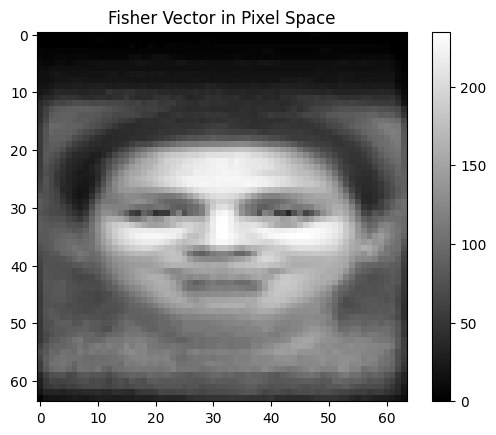

In [12]:
# Reconstruct the Fisher vector in pixel space
fisher_in_pixel_space = pca.inverse_transform(fisher_vectors.T).reshape(64, 64)

# Display the Fisher image
plt.imshow(fisher_in_pixel_space, cmap='gray')
plt.title("Fisher Vector in Pixel Space")
plt.colorbar()
plt.show()


## Part 3:

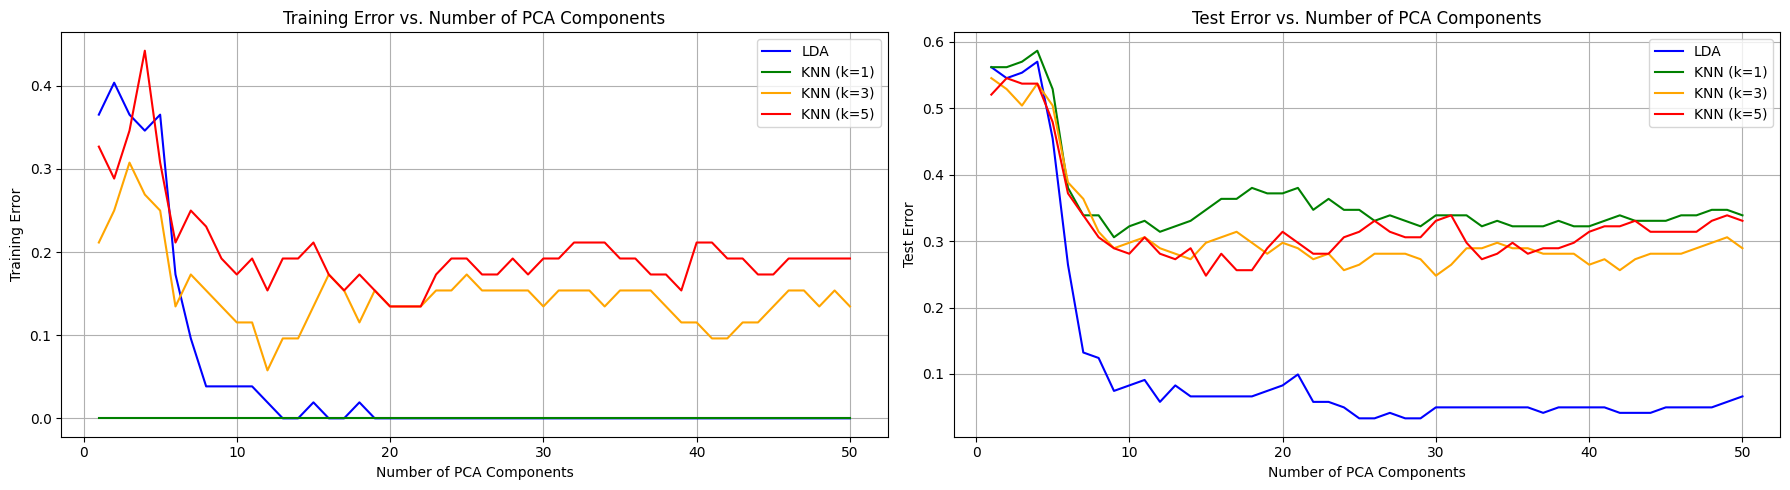

In [15]:
# Store training and testing errors for LDA and KNN
errors_train_lda = []
errors_test_lda = []
errors_train_knn = {1: [], 3: [], 5: []}
errors_test_knn = {1: [], 3: [], 5: []}

# Loop for different numbers of components from 1 to 50
for n_components in range(1, 51):
    # Dimensionality reduction with PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # LDA model
    lda = LinearDiscriminantAnalysis(n_components=1)
    # lda = LDA(n_components=1)

    lda.fit(X_train_pca, y_train)
    train_error_lda = 1 - lda.score(X_train_pca, y_train)
    test_error_lda = 1 - lda.score(X_test_pca, y_test)
    
    # Store LDA error
    errors_train_lda.append(train_error_lda)
    errors_test_lda.append(test_error_lda)
    
    # KNN model for k=1, 3, 5
    for k in [1, 3, 5]:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_pca, y_train)
        
        train_error_knn = 1 - knn.score(X_train_pca, y_train)
        test_error_knn = 1 - knn.score(X_test_pca, y_test)
        
        # Store KNN error
        errors_train_knn[k].append(train_error_knn)
        errors_test_knn[k].append(test_error_knn)

# Plot results for training and testing data
plt.figure(figsize=(18, 5))

# Training data error
plt.subplot(1, 2, 1)
plt.plot(range(1, 51), errors_train_lda, label="LDA", color='blue')
plt.plot(range(1, 51), errors_train_knn[1], label="KNN (k=1)", color='green')
plt.plot(range(1, 51), errors_train_knn[3], label="KNN (k=3)", color='orange')
plt.plot(range(1, 51), errors_train_knn[5], label="KNN (k=5)", color='red')
plt.xlabel("Number of PCA Components")
plt.ylabel("Training Error")
plt.title("Training Error vs. Number of PCA Components")
plt.grid(True)
plt.legend()

# Testing data error
plt.subplot(1, 2, 2)
plt.plot(range(1, 51), errors_test_lda, label="LDA", color='blue')
plt.plot(range(1, 51), errors_test_knn[1], label="KNN (k=1)", color='green')
plt.plot(range(1, 51), errors_test_knn[3], label="KNN (k=3)", color='orange')
plt.plot(range(1, 51), errors_test_knn[5], label="KNN (k=5)", color='red')
plt.xlabel("Number of PCA Components")
plt.ylabel("Test Error")
plt.title("Test Error vs. Number of PCA Components")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


what if

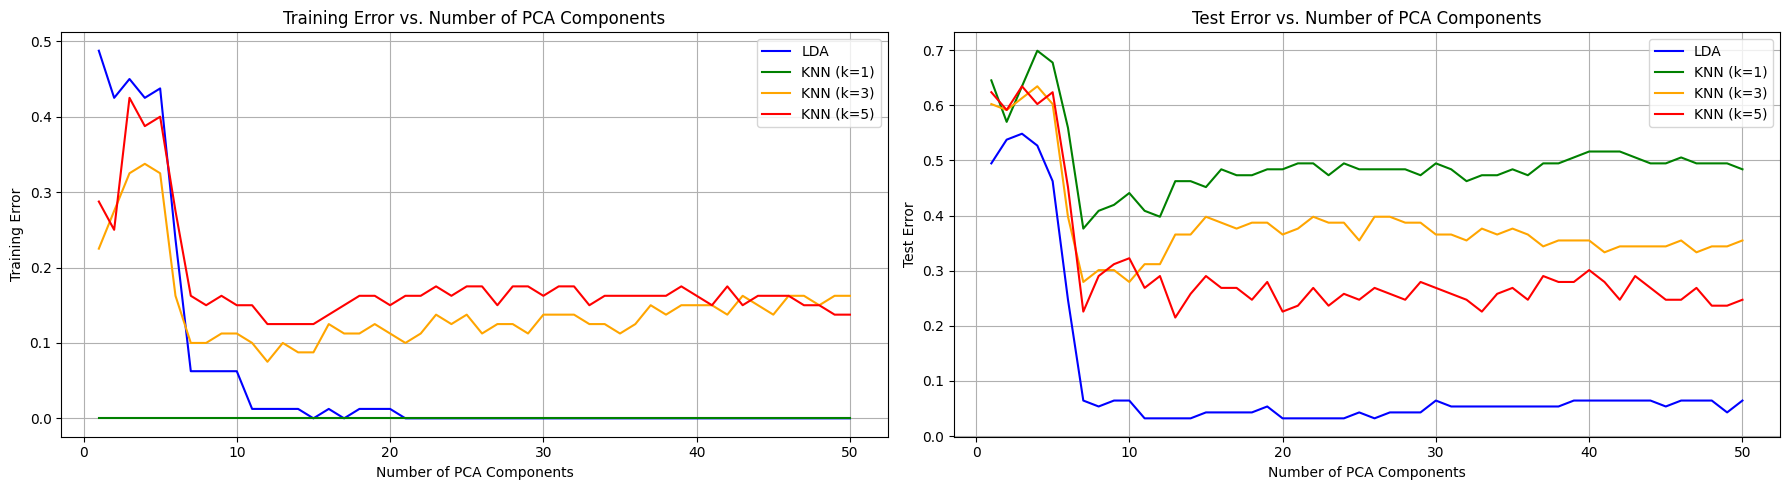

In [17]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, stratify=labels, train_size=80, random_state=42)

# Store training and testing errors for LDA and KNN
errors_train_lda = []
errors_test_lda = []
errors_train_knn = {1: [], 3: [], 5: []}
errors_test_knn = {1: [], 3: [], 5: []}

# Loop for different numbers of components from 1 to 50
for n_components in range(1, 51):
    # Dimensionality reduction with PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # LDA model
    lda = LinearDiscriminantAnalysis(n_components=1)
    # lda = LDA(n_components=1)

    lda.fit(X_train_pca, y_train)
    train_error_lda = 1 - lda.score(X_train_pca, y_train)
    test_error_lda = 1 - lda.score(X_test_pca, y_test)
    
    # Store LDA error
    errors_train_lda.append(train_error_lda)
    errors_test_lda.append(test_error_lda)
    
    # KNN model for k=1, 3, 5
    for k in [1, 3, 5]:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_pca, y_train)
        
        train_error_knn = 1 - knn.score(X_train_pca, y_train)
        test_error_knn = 1 - knn.score(X_test_pca, y_test)
        
        # Store KNN error
        errors_train_knn[k].append(train_error_knn)
        errors_test_knn[k].append(test_error_knn)

# Plot results for training and testing data
plt.figure(figsize=(18, 5))

# Training data error
plt.subplot(1, 2, 1)
plt.plot(range(1, 51), errors_train_lda, label="LDA", color='blue')
plt.plot(range(1, 51), errors_train_knn[1], label="KNN (k=1)", color='green')
plt.plot(range(1, 51), errors_train_knn[3], label="KNN (k=3)", color='orange')
plt.plot(range(1, 51), errors_train_knn[5], label="KNN (k=5)", color='red')
plt.xlabel("Number of PCA Components")
plt.ylabel("Training Error")
plt.title("Training Error vs. Number of PCA Components")
plt.grid(True)
plt.legend()

# Testing data error
plt.subplot(1, 2, 2)
plt.plot(range(1, 51), errors_test_lda, label="LDA", color='blue')
plt.plot(range(1, 51), errors_test_knn[1], label="KNN (k=1)", color='green')
plt.plot(range(1, 51), errors_test_knn[3], label="KNN (k=3)", color='orange')
plt.plot(range(1, 51), errors_test_knn[5], label="KNN (k=5)", color='red')
plt.xlabel("Number of PCA Components")
plt.ylabel("Test Error")
plt.title("Test Error vs. Number of PCA Components")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
